In [3]:
%matplotlib inline

import glob
import os
import numpy as np
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from utils import DATA_DIR, SESSION_NAME, SESSION_DATA, SESSION_EVENTS, \
    from_str_labels_to_id_labels
import xml.etree.ElementTree as ET


def read_project_data():
    project_data = {}
    
    data_length = None
    
    for file_name in glob.glob(os.path.join(DATA_DIR, '*.txt')):
        project_name = file_name[file_name.rfind('/') + 1:]
        project_name = project_name[:len(project_name)-4]
        project_data[project_name] = []


        tree = ET.parse(file_name)

        doc = tree.getroot()


        for session_element in doc.findall('session'):
            session_data = {}

            session_name = session_element.attrib['name']

            session_data[SESSION_NAME] = session_name
            session_data[SESSION_DATA] = []
            session_data[SESSION_EVENTS] = []

            frame_elements = session_element.findall('data/frame')

            for frame_element in frame_elements:
                object_point_elements = frame_element.findall('o')

                point_data = []
                for object_point_element in object_point_elements:
                    for s in object_point_element.text.split(','):
                        point_data.append(float(s))
                        
                if data_length == None:
                    data_length = len(point_data)

                session_data[SESSION_DATA].append(point_data)
            
            '''
            Calculate the difference of data points -> gradient feature
            Move all points to the same coordinations
            '''
            #session_data[SESSION_DATA] = [[(session_data[SESSION_DATA][i][t] - session_data[SESSION_DATA][0][0])\
            #     for t in xrange(data_length)]\
            #     for i in xrange(0, len(session_data[SESSION_DATA]))]
            
            project_data[project_name].append(session_data) 
            
    return data_length, project_data
    
'''
Find planes for projection of data from DATA_DIR 
'''
all_rig_points = []
all_object_points = []

no_of_samples = 0

for file_name in glob.glob(os.path.join(DATA_DIR, '*.txt')):
    tree = ET.parse(file_name)
    doc = tree.getroot()
    for session_element in doc.findall('session'):
        frame_elements = session_element.findall('data/frame')

        for frame_element in frame_elements:
            object_point_elements = frame_element.findall('o')

            rig = object_point_elements[0]
            o1, o2 = object_point_elements[1], object_point_elements[2]

            rig_points = []
            for s in rig.text.split(','):
                rig_points.append(float(s))
            
            # Extracted rig points
#             extracted_rig_points = []
#             extracted_rig_points.append( (intra_rig_data[1] + intra_rig_data[7] ) / 2 )
#             extracted_rig_points.append( intra_rig_data[5] )
#             extracted_rig_points.append( intra_rig_data[11] )

            o1_points = []
            for s in o1.text.split(','):
                o1_points.append(float(s))

            o2_points = []
            for s in o2.text.split(','):
                o2_points.append(float(s))


            all_rig_points.append(rig_points)
            all_object_points.append(o1_points)
            all_object_points.append(o2_points)
            
print 'Finish reading data '

# (13 * samples, 3)
all_rig_array = np.array(all_rig_points).reshape((-1, 3))

print (all_rig_array.shape)

# (8 * samples, 3)
all_object_array = np.array(all_object_points).reshape((-1, 3))

print (all_object_array.shape)

'''
PCA for inter-object relationship
This PCA would be an estimation of projecting on the table surface
'''
inter_object_pca = PCA(n_components=2)
all_points = np.concatenate((all_rig_array, all_object_array), axis = 0)

# (13 * samples + 8 * samples, 2)
inter_object_pca.fit(all_points)

'''
PCA for intra-object relationship
'''
intra_object_pca = PCA(n_components=2)

intra_object_pca.fit(all_object_array)

'''
PCA for intra-rig relationship
This would be a good 
'''
intra_rig_pca = PCA(n_components=2)

intra_rig_pca.fit(all_rig_array)

print 'Finish traing PCAs'

Finish reading data 
(375726L, 3L)
(231216L, 3L)
Finish traing PCAs


In [32]:
data_length = None
_, project_data = read_project_data()

def plot_project(project_name, sessionIndex = 0, labels = ['shoulder_middle', 'right_hand_tip', 'left_hand_tip', 'o1_centroid', 'o2_centroid', 
             'average_shoulders', 'left_hand_on_rig', 'right_hand_on_rig', 
             'o1_corner1', 'o1_corner2','o2_corner1','o2_corner2'], figsize = (5, 7), axis = [-1,1.2,-1,1]):
    no_of_points = len(labels)
    colormaps_fig = plt.figure(figsize = (5, 7))
    ax = colormaps_fig.add_subplot(111)

    # Draw the plot
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, no_of_points)])
    
    plt.axis ( axis )

    session_data = project_data[project_name][sessionIndex]
    print '-----------------------------------'
    print project_name
    print '-----------------------------------'
    point_datas = session_data[SESSION_DATA]

    new_session_datas = []

    for point_data in point_datas:
        new_session_data = []

        "---------------------------------------------"
        # (21, 2)
        inter_object_data = inter_object_pca.transform( np.array(point_data).reshape((-1, 3)) )

        # Centroid of three objects projected using inter_object_pca
        if 'shoulder_middle' in labels:
            new_session_data.append( (inter_object_data[1] + inter_object_data[7] ) / 2 )
        if 'right_hand_tip' in labels:
            new_session_data.append( np.average( inter_object_data[5:6], axis = 0 ) )
        if 'left_hand_tip' in labels:
            new_session_data.append( np.average( inter_object_data[11:12], axis = 0 ) )
        if 'o1_centroid' in labels:
            new_session_data.append( np.average( inter_object_data[13:17], axis = 0 ) )
        if 'o2_centroid' in labels:
            new_session_data.append( np.average( inter_object_data[17:21], axis = 0 ) )

        "---------------------------------------------"
        # (21, 2)
        intra_rig_data = intra_rig_pca.transform( np.array(point_data).reshape((-1, 3)) )
    
        # Average of two shoulders
        if 'average_shoulders' in labels:
            new_session_data.append( (intra_rig_data[1] + intra_rig_data[7] ) / 2 )

        # Hand tip left
        if 'left_hand_on_rig' in labels:
            new_session_data.append( intra_rig_data[5] )

        # Hand tip right
        if 'right_hand_on_rig' in labels:
            new_session_data.append( intra_rig_data[11] )

        "---------------------------------------------"
        intra_object_data = intra_object_pca.transform( np.array(point_data).reshape((-1, 3)) )

        # Corners of objects (for each object, just pick two corners)
        if 'o1_corner1' in labels:
            new_session_data.append( intra_object_data[13] )
        if 'o1_corner2' in labels:
            new_session_data.append( intra_object_data[15] )
        if 'o2_corner1' in labels:
            new_session_data.append( intra_object_data[17] )
        if 'o2_corner2' in labels:
            new_session_data.append( intra_object_data[19] )

        point_data = np.concatenate( new_session_data )

        new_session_datas.append( point_data )
    
    # (sample_size, 16 )
    new_session_datas = np.array(new_session_datas)

    # 8 different points' trajectories
    handles = []
    for i in xrange(no_of_points):
        x = new_session_datas[:, 2 * i]
        y = new_session_datas[:, 2 * i + 1]
        
        ax.annotate('Start', xy=(x[0], y[0]), xytext=(x[0] + 0.05, y[0] + 0.05),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
        
        h, = plt.plot(x, y, label = labels[i])

        handles.append(h)
        
    plt.legend(handles=handles)
    
    return new_session_datas

['C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollpast', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullfrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslidepast', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfrollto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfrollfrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullpast', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushpast', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfrollpast', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslidefrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollfrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushfrom']


-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


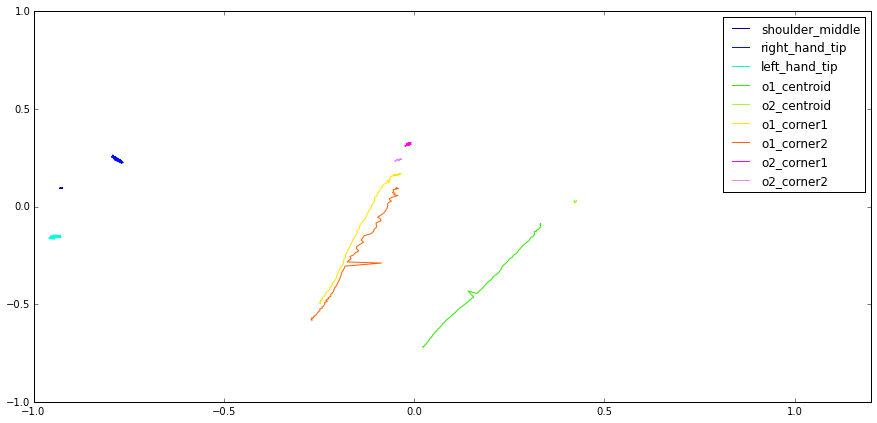

In [4]:
sample = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\rollpast
-----------------------------------


array([[-0.4730724 , -0.20131727, -0.37011291, ..., -0.34875523,
         0.16078643, -0.45150624],
       [-0.4730724 , -0.20131727, -0.37011291, ..., -0.34875523,
         0.09632309, -0.4426177 ],
       [-0.47523015, -0.20290259, -0.37044407, ..., -0.34867455,
         0.1396058 , -0.4473518 ],
       ..., 
       [-0.13475977,  0.10842869,  0.15936661, ...,  0.43961693,
         0.03493887,  0.42650646],
       [-0.13571893,  0.10707927,  0.17172414, ...,  0.47323383,
         0.1180138 ,  0.40628838],
       [-0.13550538,  0.10650725,  0.17163499, ...,  0.47551398,
         0.12301886,  0.40936289]])

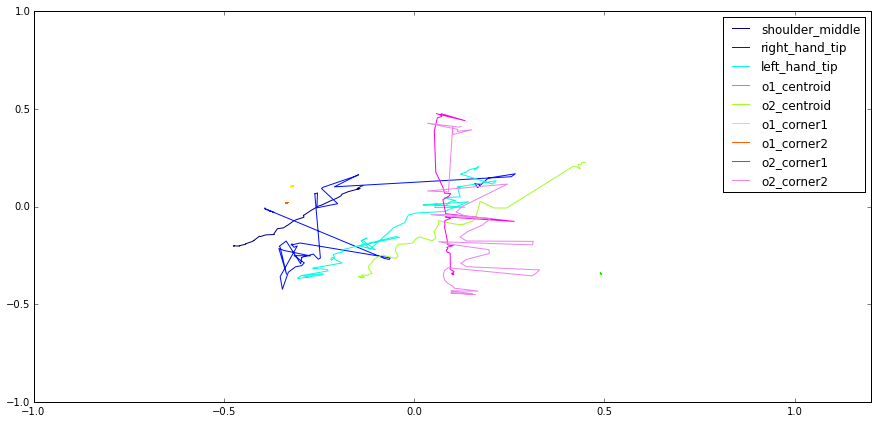

In [286]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollpast')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pullpast
-----------------------------------


array([[ 0.36882864,  0.19047585,  0.6255906 , ..., -0.19737135,
         0.14537679, -0.28391797],
       [ 0.36882864,  0.19047585,  0.6255906 , ..., -0.19737135,
         0.14537679, -0.28391797],
       [ 0.36882864,  0.19047585,  0.6255906 , ..., -0.19737135,
         0.14342057, -0.28409025],
       ..., 
       [ 0.3489498 ,  0.49825973,  0.62133589, ..., -0.19795679,
         0.14635493, -0.28383192],
       [ 0.34873028,  0.4982369 ,  0.6246377 , ..., -0.19824951,
         0.14439868, -0.28400411],
       [ 0.34820214,  0.49839916,  0.62198345, ..., -0.19824951,
         0.14537679, -0.28391797]])

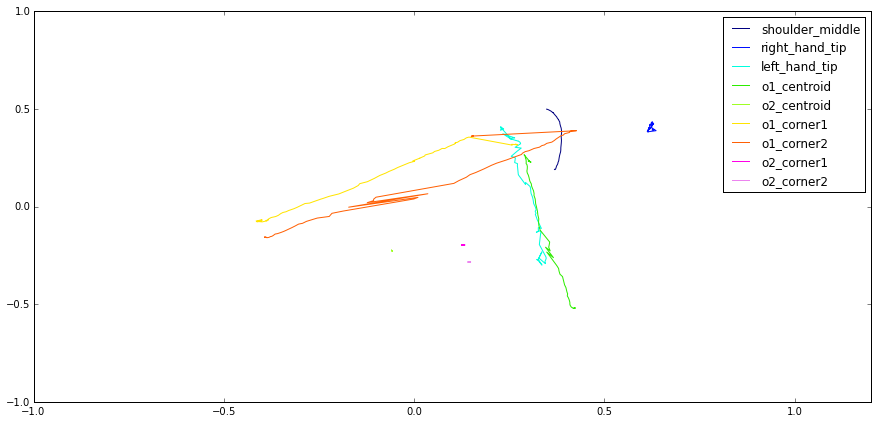

In [288]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullpast', 4)

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pullfrom
-----------------------------------


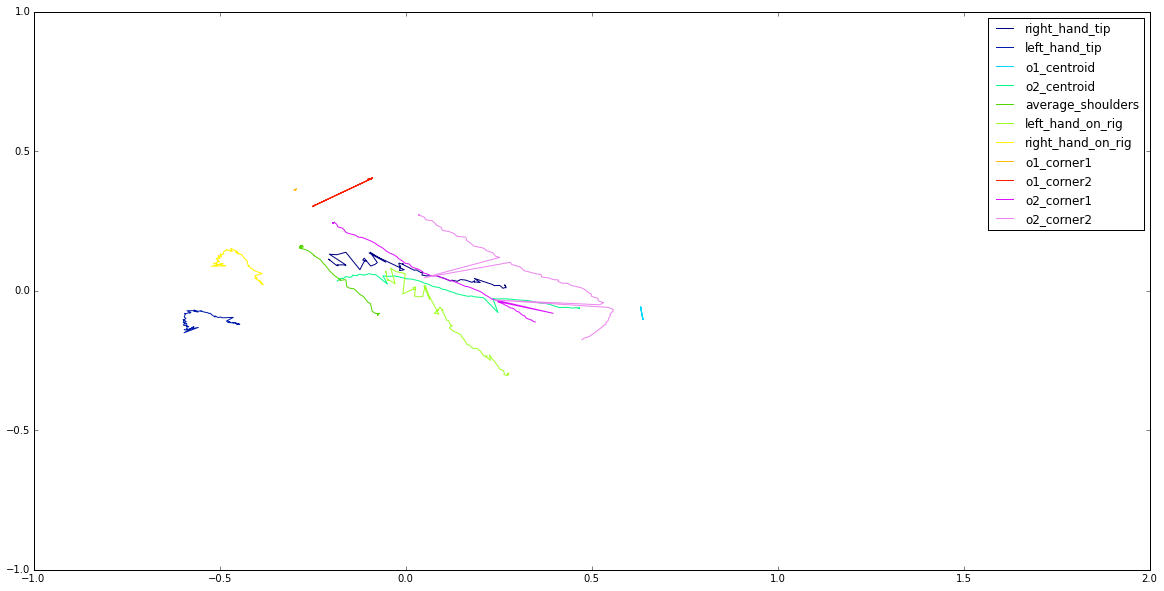

In [66]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullfrom')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pushto
-----------------------------------


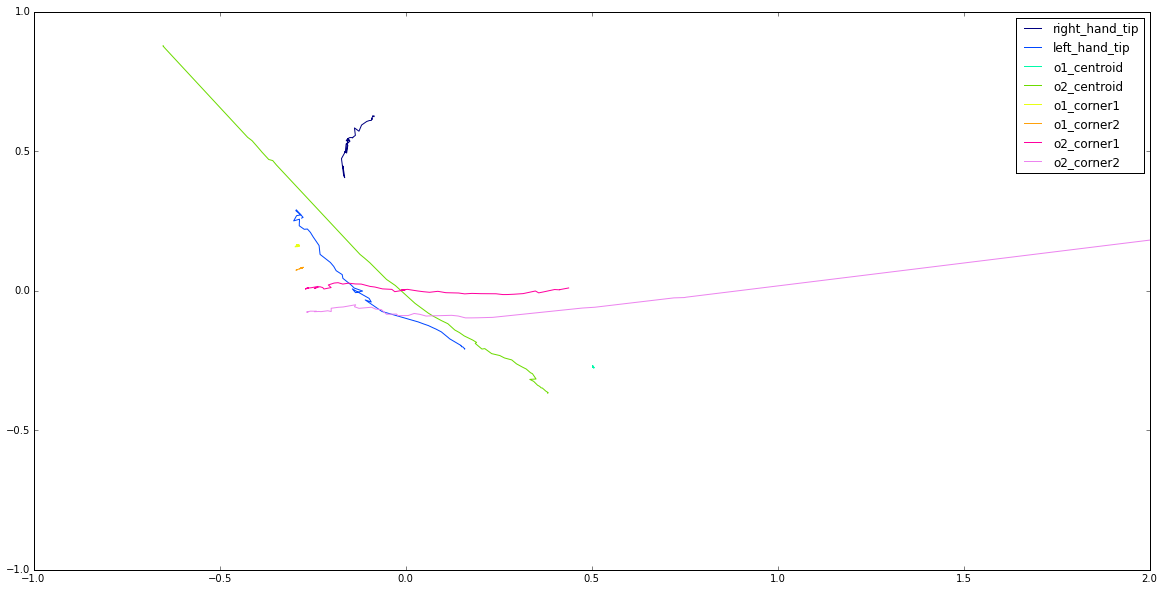

In [73]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushto')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pushfrom
-----------------------------------


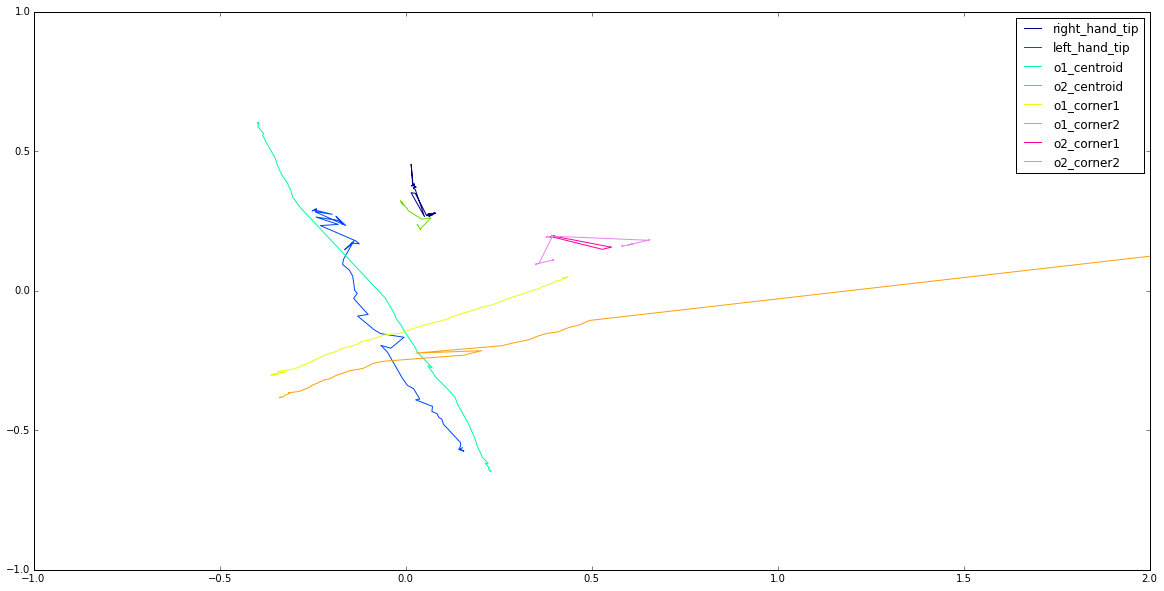

In [74]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushfrom')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


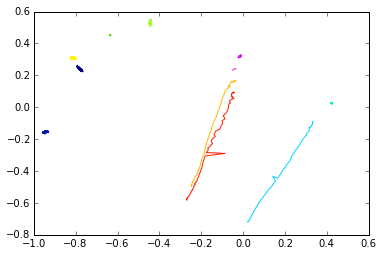

In [22]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


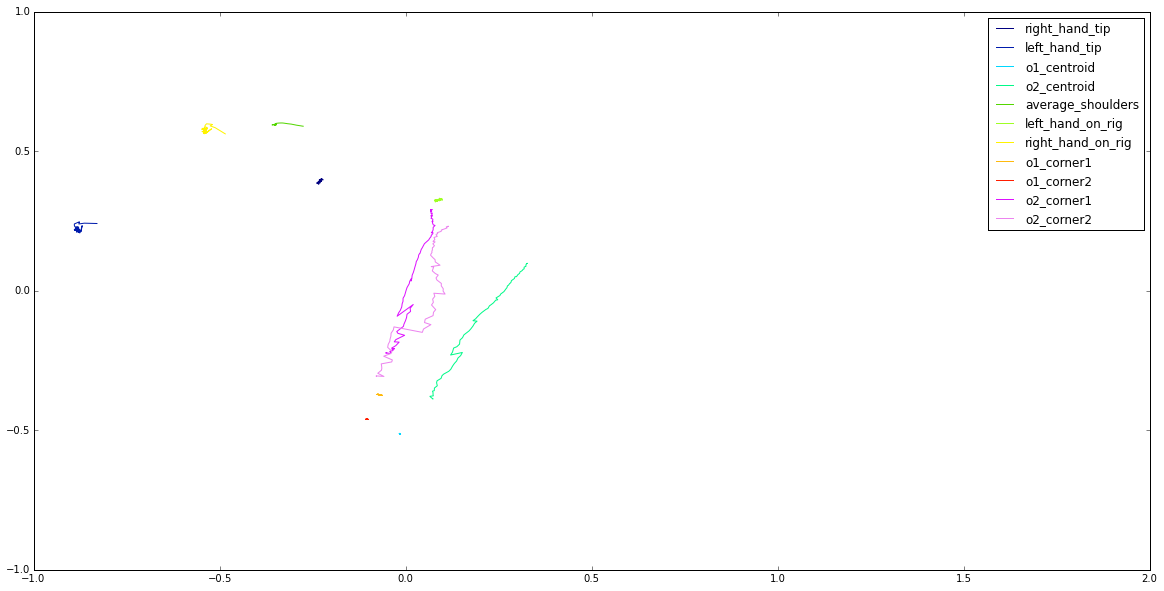

In [61]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto', 1)

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


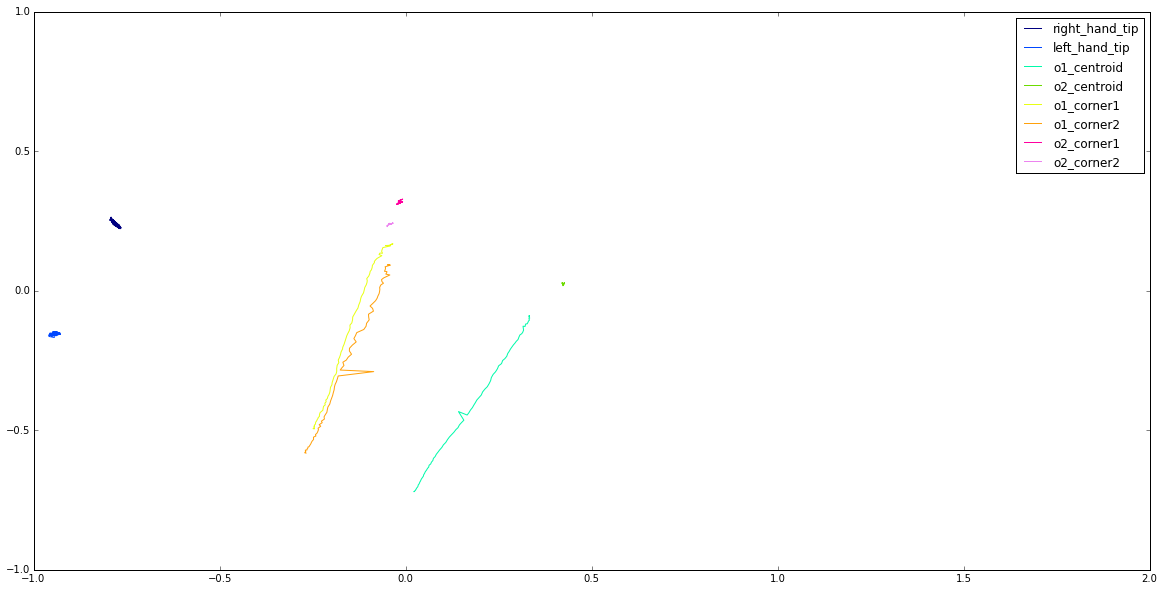

In [1]:

import sys
sys.path.append('C:\Users\Tuan\git\strands_qsr_lib\qsr_lib\src')
from qsrlib.qsrlib import QSRlib, QSRlib_Request_Message

from qsrlib_io.world_trace import Object_State, World_Trace

def pretty_print_world_qsr_trace(which_qsr, qsrlib_response_message):
    print(which_qsr, "request was made at ", str(qsrlib_response_message.req_made_at)
          + " and received at " + str(qsrlib_response_message.req_received_at)
          + " and computed at " + str(qsrlib_response_message.req_finished_at))
    print("---")
    print("Response is:")
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        foo = str(t) + ": "
        for k, v in zip(qsrlib_response_message.qsrs.trace[t].qsrs.keys(),
                        qsrlib_response_message.qsrs.trace[t].qsrs.values()):
            foo += str(k) + ":" + str(v.qsr) + "; "
        print(foo)
        
qsrlib = QSRlib()

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


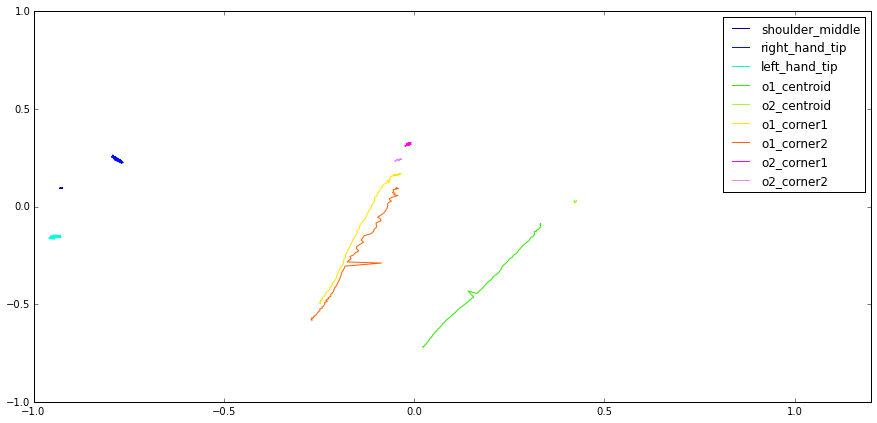

In [4]:
sample = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto')

In [23]:
qtcc_relations = dict( (u, i) for (i, u) in enumerate( ['-', '0', '+'] ))

def qtcc_index ( qtcc_relation ):
    return qtcc_relations [qtcc_relation] - 1

def turn_qtcc_to_features(keys, qsrlib_response_message):
    feature_chain = []
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        features = []
        # print (qsrlib_response_message.qsrs.trace[t].qsrs.keys())
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]

                if 'qtccs' in v.qsr:
                    fs = v.qsr['qtccs']
                    features.append([qtcc_index(f) for f  in fs.split(',')])
                
        feature_chain.append(features)
    
    #feature_chain[0] += [0, 0, 0]
    
    #feature_chain = [ [feature_chain[t + 1][i] - feature_chain[t][i] for i in xrange(len(feature_chain[0])) ]
    #              for t in xrange(len(feature_chain) - 1)]
    
    #feature_chain = [[0 for i in xrange(len(feature_chain[0]))]] +  feature_chain
    return feature_chain

def print_qtccs(sample):

    o1_corner1 = [Object_State(name="o1_corner1", timestamp=i, x=sample[i][10], y=sample[i][11], width=1, length=1) 
          for i in xrange(sample.shape[0])]

    o1_corner2 = [Object_State(name="o1_corner2", timestamp=i, x=sample[i][12], y=sample[i][13], width=1, length=1) 
          for i in xrange(sample.shape[0])]

    o1_centroid = [Object_State(name="o1_centroid", timestamp=i, x=sample[i][6], y=sample[i][7], width=1, length=1) 
          for i in xrange(sample.shape[0])]

    o2_centroid = [Object_State(name="o2_centroid", timestamp=i, x=sample[i][8], y=sample[i][9], width=1, length=1) 
          for i in xrange(sample.shape[0])]

    world = World_Trace()
    world.add_object_state_series(o1_corner1)
    world.add_object_state_series(o1_corner2)
    world.add_object_state_series(o1_centroid)
    world.add_object_state_series(o2_centroid)

    qsrlib_request_message = QSRlib_Request_Message(which_qsr=['qtccs'], input_data=world, 
                    dynamic_args = {'qtccs': {'qsrs_for': [ ('o1_centroid', 'o2_centroid')], 
                                              'quantisation_factor': 0.001, 'angle_quantisation_factor' : np.pi / 5,
                                              #'validate': False, 'no_collapse': True
                                   }})
    # request your QSRs
    qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

#     pretty_print_world_qsr_trace(['qtccs', 
#                                   'cardir', 'argd'], qsrlib_response_message)
    
    for stuff in turn_qtcc_to_features(['o1_centroid,o2_centroid'], qsrlib_response_message):
        print stuff
    
print_qtccs(sample)

[[0, 1, 0, 1]]
[[0, 0, 0, 0]]
[[-1, 1, 0, 0]]
[[0, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[0, 0, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 1, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, 1, -1, 0]]
[[-1, 0, 0, 0]]
[[-1, 0, 1, 0]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, 0]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1, 0, 0, 0]]
[[-1, 1, 0, 1]]
[[-1, 0, 0, 0]]
[[-1, -1, 0, -1]]
[[-1

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\rollpast
-----------------------------------


NameError: name 'print_qtccs' is not defined

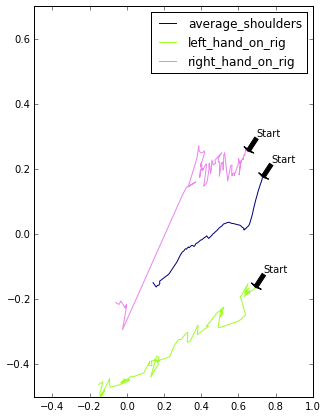

In [33]:
labels = ['shoulder_middle', 'right_hand_tip', 'left_hand_tip', 'o1_centroid', 'o2_centroid', 
             'average_shoulders', 'left_hand_on_rig', 'right_hand_on_rig', 
             'o1_corner1', 'o1_corner2','o2_corner1','o2_corner2']
figsize = (10, 5)
axis = [-0.5,1,-0.5,0.7]
sample2 = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollpast', 2, ['average_shoulders', 'left_hand_on_rig', 'right_hand_on_rig'], figsize,
                      axis)

print_qtccs(sample2) 

In [186]:
o1_corner1 = [Object_State(name="o1_corner1", timestamp=i, x=sample2[i][12], y=sample2[i][13], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

o1_corner2 = [Object_State(name="o1_corner2", timestamp=i, x=sample2[i][14], y=sample2[i][15], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

o1_centroid = [Object_State(name="o1_centroid", timestamp=i, x=sample2[i][4], y=sample2[i][5], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

o2_centroid = [Object_State(name="o2_centroid", timestamp=i, x=sample2[i][6], y=sample2[i][7], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

world = World_Trace()
world.add_object_state_series(o1_corner1)
world.add_object_state_series(o1_corner2)
world.add_object_state_series(o1_centroid)
world.add_object_state_series(o2_centroid)

qsrlib_request_message = QSRlib_Request_Message(which_qsr=[#'qtccs', 
                                                           'cardir', 'mos', 'argd'], input_data=world, 
                dynamic_args = {#'qtccs': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')]},
                               'cardir': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')]},
                                'mos' : {'qsrs_for': ['o1_centroid', 'o2_centroid'], 'quantisation_factor': 0.005},
                               'argd': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')], 
                                        'qsr_relations_and_values' : dict(("" + str(i), i * 1.0 / 20) for i in xrange(20)) }})
# request your QSRs
qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

pretty_print_world_qsr_trace([#'qtccs', 
                              'cardir', 'mos', 'argd'], qsrlib_response_message)

(['cardir', 'mos', 'argd'], 'request was made at ', '2017-04-18 15:37:17.006000 and received at 2017-04-18 15:37:17.006000 and computed at 2017-04-18 15:37:17.020000')
---
Response is:
0.0: o1_corner1,o1_corner2:{'cardir': 'nw', 'argd': '3'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
1.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2'}; o2_centroid:{'mos': 'm'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
2.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '3'}; o2_centroid:{'mos': 'm'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
3.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'nw', 'argd': '3'}; o2_centroid:{'mos': 's'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
4.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '3'}; o2_centroid:{'mos': 's'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
5.0: o1_centroid:{'mos': 's'}; o1_corner

In [54]:
cdid = dict( (u, i) for (i, u) in enumerate( ['n', 'nw', 'w', 'sw', 's', 'se', 'e', 'ne', 'eq'] ))
mosd = dict( (u, i) for (i, u) in enumerate( ['s', 'm'] ))
qtcc_relations = dict( (u, i) for (i, u) in enumerate( ['-', '0', '+'] ))

def cardir_index ( cardir ):
    return cdid [cardir]

def mos_index ( mos ):
    return mosd [mos]

def qtcc_index ( qtcc_relation ):
    return qtcc_relations [qtcc_relation] - 1

def turn_response_to_features(keys, qsrlib_response_message):
    feature_chain = []
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        features = []
        # print (qsrlib_response_message.qsrs.trace[t].qsrs.keys())
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]

                if 'cardir' in v.qsr:
                    f = v.qsr['cardir']
                    features.append(cardir_index(f))
                if 'argd' in v.qsr:
                    f = int( v.qsr['argd'] )
                    features.append(f)
                if 'mos' in v.qsr:
                    f = v.qsr['mos'] 
                    features.append(mos_index(f))
        # Just to separate qtccs at the end of feature vectors
        
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]
                if 'qtccs' in v.qsr:
                    fs = v.qsr['qtccs']
                    features += [qtcc_index(f) for f  in fs.split(',')]
        
        # print features
        feature_chain.append(features)
    
    if len(feature_chain) == 0:
        return feature_chain

    # The first frame doesn't has dyadic relation
    feature_chain[0] += [0, 0, 0, 0, 0, 0, 0]
    
    diff_feature_chain = [ [feature_chain[t + 1][i] - feature_chain[t][i] 
                            for i in xrange(len(feature_chain[0]) - 7) ] + \
                          [feature_chain[t][i] for i in xrange(len(feature_chain[0]) - 7, len(feature_chain[0]))]
                    for t in xrange(len(feature_chain) - 1)]
    
    diff_feature_chain = [[0 for i in xrange(len(feature_chain[0]))]] +  diff_feature_chain

    # Concatenate features
    # feature_chain = [feature_chain[i] + diff_feature_chain[i] for i in xrange(len(feature_chain))]

    return diff_feature_chain
        

def qsr_feature_extractor ( qsrlib, session_data ):
    '''
    List of features from qsr

    25 features

    ('body', 'left_hand') - cardir_diff, argd_diff
    ('body', 'right_hand') - cardir_diff, argd_diff 
    ('left_hand', 'o1_centroid') - cardir_diff, argd_diff 
    ('right_hand', 'o1_centroid') - cardir_diff, argd_diff 
    ('left_hand', 'o2_centroid') - cardir_diff, argd_diff
    ('right_hand', 'o2_centroid') - cardir_diff, argd_diff 
    ('o1_centroid', 'o2_centroid') - cardir_diff, argd_diff 
    ('o1_corner1','o1_corner2') - cardir_diff, argd_diff 
    ('o2_corner1','o2_corner2') - cardir_diff, argd_diff
    'body' - mos
    'o1_centroid' - mos
    'o2_centroid' - mos
    ('o1_centroid', 'o2_centroid') - qtccs features
    '''

    data_length = len(session_data)
    # body centroid
    body_centroid = [Object_State(name="body", timestamp=i, x=session_data[i][0], y=session_data[i][1], width=0.1, length=0.1) 
      for i in xrange(data_length)]
    
    # left hand tip
    left_hand = [Object_State(name="left_hand", timestamp=i, x=session_data[i][2], y=session_data[i][3], width=0.1, length=0.1) 
      for i in xrange(data_length)]
    
    # right hand tip
    right_hand = [Object_State(name="right_hand", timestamp=i, x=session_data[i][4], y=session_data[i][5], width=0.1, length=0.1) 
      for i in xrange(data_length)]
    
    # centroid of o1 object
    o1_centroid = [Object_State(name="o1_centroid", timestamp=i, x=session_data[i][6], y=session_data[i][7], width=0.1, length=0.1) 
          for i in xrange(data_length)]
    
    # centroid of o2 object
    o2_centroid = [Object_State(name="o2_centroid", timestamp=i, x=session_data[i][8], y=session_data[i][9], width=0.1, length=0.1) 
          for i in xrange(data_length)]
    
    # o1
    o1_corner1 = [Object_State(name="o1_corner1", timestamp=i, x=session_data[i][10], y=session_data[i][11], width=0.1, length=0.1) 
          for i in xrange(data_length)]
    
    o1_corner2 = [Object_State(name="o1_corner2", timestamp=i, x=session_data[i][12], y=session_data[i][13], width=0.1, length=0.1) 
          for i in xrange(data_length)]
    
    # o2
    o2_corner1 = [Object_State(name="o2_corner1", timestamp=i, x=session_data[i][14], y=session_data[i][15], width=0.1, length=0.1) 
          for i in xrange(data_length)]
    
    o2_corner2 = [Object_State(name="o2_corner2", timestamp=i, x=session_data[i][16], y=session_data[i][17], width=0.1, length=0.1) 
          for i in xrange(data_length)]

    

    world = World_Trace()
    world.add_object_state_series(body_centroid)
    world.add_object_state_series(left_hand)
    world.add_object_state_series(right_hand)
    world.add_object_state_series(o1_centroid)
    world.add_object_state_series(o2_centroid)
    world.add_object_state_series(o1_corner1)
    world.add_object_state_series(o1_corner2)
    world.add_object_state_series(o2_corner1)
    world.add_object_state_series(o2_corner2)
    
    interest_argd_pairs = [('body', 'left_hand'), ('body', 'right_hand'), ('left_hand', 'o1_centroid'), 
                           ('right_hand', 'o1_centroid'), ('left_hand', 'o2_centroid'), 
                           ('right_hand', 'o2_centroid'), ('o1_centroid', 'o2_centroid'), 
                           ('o1_corner1','o1_corner2'), ('o2_corner1','o2_corner2')]
    interest_cardir_pairs = interest_argd_pairs
    
    interest_argd_pair_keys = [u + ',' + v for (u, v) in interest_argd_pairs]
    
    interest_mos_elements = ['body', 'o1_centroid', 'o2_centroid']
    
    interest_cctcs_pair_keys = [('o1_centroid', 'o2_centroid')]
    
    qsrlib_request_message = QSRlib_Request_Message(which_qsr=['cardir', 'mos', 'argd', 'qtccs'], input_data=world, 
                    dynamic_args = {'cardir': {'qsrs_for': interest_cardir_pairs},
                                    'mos' : {'qsrs_for': interest_mos_elements, 'quantisation_factor': 0.005},
                                    'argd': {'qsrs_for': interest_argd_pairs, 
                                            'qsr_relations_and_values' : dict(("" + str(i), i * 1.0 / 20) for i in xrange(20)) },
                                    'qtccs': {'qsrs_for': interest_cctcs_pair_keys, 
                                              'quantisation_factor': 0.001, 'angle_quantisation_factor' : np.pi / 5,
                                              'validate': False, 'no_collapse': True
                                   }})
    # request your QSRs
    qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

    # pretty_print_world_qsr_trace(['cardir', 'mos', 'argd', 'qtccs'], qsrlib_response_message)
    
    return turn_response_to_features(interest_argd_pair_keys + interest_mos_elements, qsrlib_response_message)

In [55]:
feature_chain = qsr_feature_extractor( qsrlib, sample)
for feature in feature_chain:
    print feature

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0]
[0,

In [59]:
feature_chain = qsr_feature_extractor( qsrlib, sample2)
for feature in feature_chain:
    print feature

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1]
[0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 1, 0, -1]
[0, 0, 0, 0, -7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 1]
[0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, -1, 0]
[0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 1, 0, 1, 0, -1, 0]
[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, -1, -1]
[0, 1, 0, 0, 0, -2, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, -1, 0]
[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -2, 0, 0, 0, 0, 1, 0, -1, -1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [32]:
qsr_feature_extractor( qsrlib, sample)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pullpast
-----------------------------------


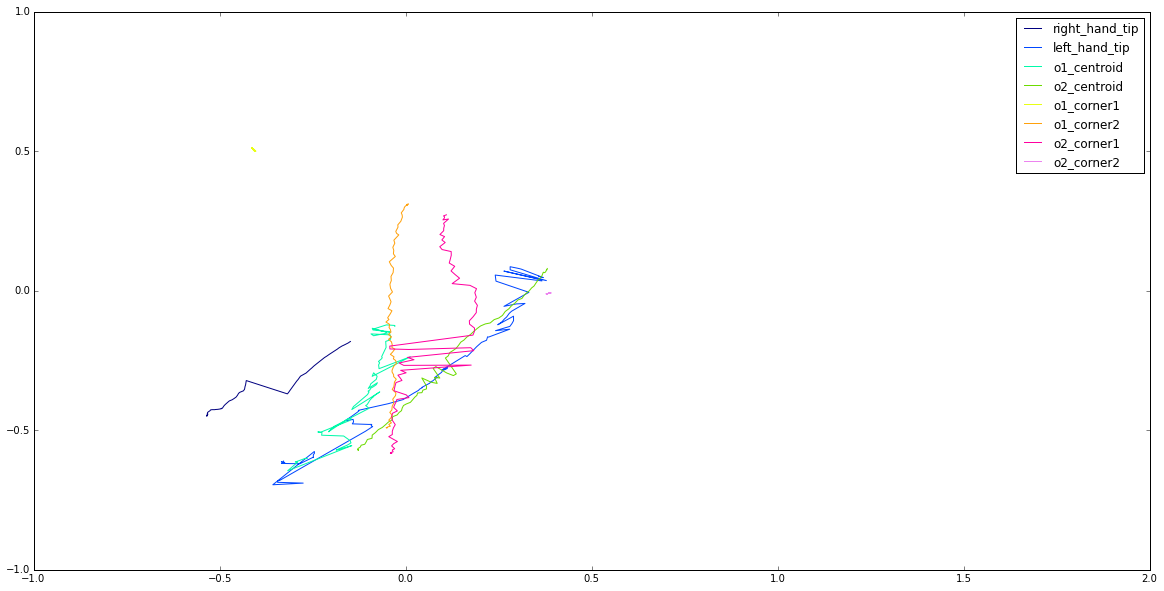

In [222]:
sample3 = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullpast')

In [223]:
qsr_feature_extractor( qsrlib, sample3)

[[3, 12, 3, 3, 3, 1, 3, 10, 5, 18, 5, 15, 5, 18, 2, 3, 2, 19],
 [3, 12, 3, 3, 3, 1, 3, 10, 5, 18, 5, 15, 5, 18, 2, 3, 2, 19, 0, 0, 0],
 [3, 12, 3, 3, 4, 1, 3, 10, 5, 18, 5, 15, 5, 18, 1, 3, 2, 19, 0, 0, 0],
 [3, 11, 3, 3, 2, 2, 3, 10, 5, 17, 5, 15, 5, 19, 2, 3, 2, 19, 0, 1, 1],
 [3, 11, 3, 3, 2, 2, 3, 10, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 0, 1],
 [3, 11, 3, 2, 2, 2, 3, 11, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 0, 0],
 [3, 11, 2, 3, 2, 2, 3, 10, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 12, 3, 2, 5, 1, 2, 10, 5, 19, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 10, 3, 2, 2, 2, 2, 10, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 12, 2, 3, 7, 1, 3, 9, 5, 19, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 12, 2, 3, 7, 1, 3, 9, 5, 19, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 1],
 [3, 10, 3, 2, 1, 3, 2, 10, 5, 16, 5, 15, 5, 18, 2, 3, 2, 19, 1, 1, 0],
 [3, 10, 3, 2, 2, 2, 2, 10, 5, 16, 5, 15, 5, 18, 2, 3, 2, 19, 1, 1, 0],
 [2, 11, 2, 3, 6, 1, 2, 8, 5, 18, 5, 16, 5, 18, 2, 3, 2, 19, 1, 1, 0],
 [2,

In [290]:
np.arccos(0.9)

0.45102681179626236

In [291]:
np.PI

AttributeError: 'module' object has no attribute 'PI'

In [292]:
long.PI

AttributeError: type object 'long' has no attribute 'PI'

In [293]:
np.pi

3.141592653589793

In [294]:
np.pi/10

0.3141592653589793

In [295]:
np.pi/20

0.15707963267948966

In [65]:
def _test_constraint_side(pos, line, quantisation_factor=0, angle_quantisation_factor=0):
        """Test for distance and side constraint using the double cross.

        To determine if a point moved, it uses a line (from the cross) and checks
        the side the point moved to (depending on the orientation of the line)
        and how far away it moved. The latter is used for the `quantisation_factor`
        and to create 0-states from noisy data.

        Example:
            * QTCBS: uses the orthogonal line going through the point to compute the distance constraint.
            * QTCCS: uses the connecting line to determine the side constraint.

        :param pos: Position of the agent, point in space.
        :type pos: ?
        :param line: Line to use as reference for the movement.
        :type line: ?
        :param quantisation_factor: Minimum distance a point has to move to be considered a non-0-state. Same unit of measurement as the described points.
        :type quantisation_factor: float
        :param angle_quantisation_factor: Minimum angle a point has to move to be considered a non-0-state. Unit of measurement is radiant.
        :type angle_quantisation_factor: float
        :param constraint: Set to "side" if checking for the side constraint. The result for the side has to be inverted.
        :type constraint: str
        :return: QTCS symbol for this movement.
        :rtype: ?
        """
        x0 = pos[-1,0]
        y0 = pos[-1,1]
        x3 = pos[0,0]
        y3 = pos[0,1]
        
        x1 = line[0,0]
        y1 = line[0,1]
        x2 = line[1,0]
        y2 = line[1,1]

        test = (x0 - x1) * (y2 - y1) - (x2 - x1) * (y0 - y1)

        d = np.abs(
            np.linalg.det(
                np.append(
                    [line[1,0:2]-line[0,0:2]],
                    [pos[-1,0:2]-line[0,0:2]]
                ).reshape(-1,2)
            )
        )/np.linalg.norm(line[1,0:2]-line[0,0:2])

        if np.abs(d) > quantisation_factor:
            angle = np.arccos( ((x0 - x3) * (x2 - x1) + (y0 - y3) * (y2 - y1)) / ( np.linalg.norm((x0 - x3, y0 - y3)) * np.linalg.norm((x2 - x1, y2 - y1)) ) )
            
        print angle
        res = 0
        if test > 0 and np.abs(d) > quantisation_factor and angle > angle_quantisation_factor:
            res = 1
        elif test < 0 and np.abs(d) > quantisation_factor and angle > angle_quantisation_factor:
            res = -1

        return res

In [50]:
_test_constraint_side( 2, 2, 1, 0, 2, 1)

NameError: global name 'line' is not defined

In [53]:
def _translate( point, trans_vec):
    """Translate points by trans_vec.

    :param point: Can be [x,y] or list of lists [[x,y],[x,y]].
    :type point: list or list of lists
    :param trans_vec: The translation vector given as [x, y].
    :type trans_vec: ?
    :return: Translated points.
    :rtype: ?
    """
    point_array = np.array(point)
    point_array = point_array + np.array(trans_vec)
    return point_array

pos_k = [ 1, 0, 2, 2]
pos_l = [ 2, 1, 2, 1]

pos_k = np.array(pos_k).reshape(-1, 2)
pos_l = np.array(pos_l).reshape(-1, 2)

RL_ext = np.append(
            _translate(pos_k[-2], (pos_k[-2]-pos_l[-2])/2),
            _translate(pos_l[-2], (pos_l[-2]-pos_k[-2])/2)
        ).reshape(-1,2)

In [69]:
_test_constraint_side( pos_k, RL_ext, quantisation_factor = 0.01, angle_quantisation_factor = np.pi/20)

0.321750554397


-1